<a href="https://colab.research.google.com/github/Anagh3/mainproject/blob/resnet50/ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# import os

# #path='/content/gdrive/MyDrive/StyleTransfer'
# path='/content/gdrive/MyDrive/'
# os.chdir(path)
# !dir

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import IPython.display
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [4]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [90]:
content_path = '/content/1c.jpg'
style_path = '/content/1s.jpeg'

In [91]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    img = img.convert("RGB")  # Convert image to RGB mode
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

In [92]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

<ipython-input-91-f1ad2ad8c269>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.ANTIALIAS)


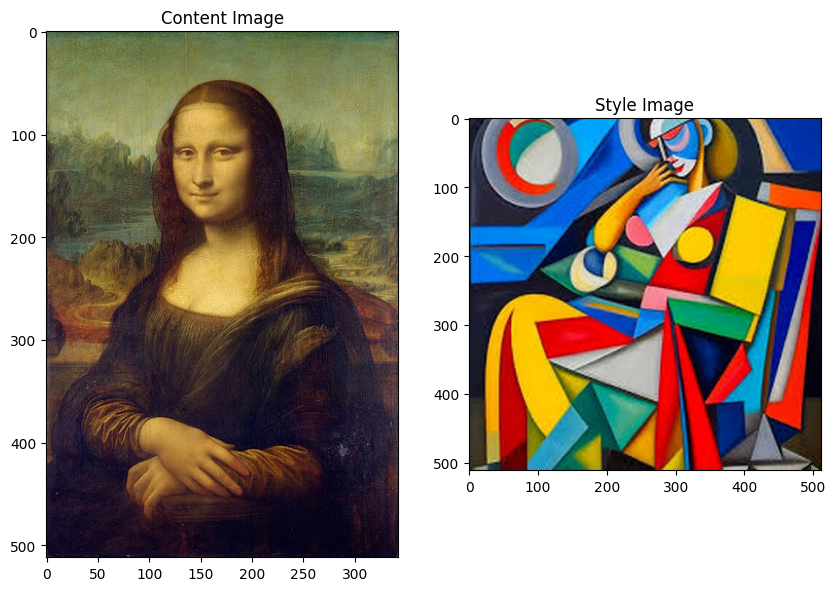

In [93]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [94]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img

In [95]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x





In [96]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [97]:
# content_layers = ['conv5_block3_out']
# style_layers = ['conv1_conv', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']

In [98]:
# content_layers = ['conv4_block6_out']
# style_layers = ['conv1_relu',  # Example layers, adjust as needed
#     'conv2_block2_out',
#     'conv3_block4_out',
#     'conv4_block6_out',
#     'conv5_block3_out']

In [99]:
# Content layer where will pull our feature maps

content_layers = ['conv1_conv']

# Style layer we are interested in
style_layers = ['conv1_bn','conv2_block2_1_bn','conv3_block1_0_conv','conv4_block6_2_bn']#,'conv1']


In [100]:
# content_layers = ['conv3_block4_out']  # Middle layers

# style_layers = [
#     'conv1_relu',                      # Early layers
#     'conv2_block3_out',
#     'conv3_block4_out',
#     'conv4_block6_out',
#     'conv5_block3_out']

In [101]:
# #new

# content_layers = ['conv3_block4_out']  # Middle layer

# style_layers = [
#     'conv1_relu',                      # Early layers
#     'conv2_block1_out',               # Initial layer of block 2
#     'conv3_block1_1_conv',               # Initial layer of block 3
#     'conv4_block1_1_conv',               # Initial layer of block 4
#     'conv5_block1_1_relu'                # Initial layer of block 5
# ]

In [102]:
# #new

# content_layers = ['conv3_block4_out']  # Middle layer

# style_layers = [
#     'conv1_conv',                      # Early layers
#     'conv2_block1_2_conv',               # Initial layer of block 2
#     'conv3_block1_2_conv',               # Initial layer of block 3
#     'conv4_block1_2_conv',               # Initial layer of block 4
#     'conv5_block1_2_conv'                # Initial layer of block 5
# ]

In [103]:
# content_layers = ['conv3_block4_out']  # Middle layer

# style_layers = [
#     'conv1_relu',                      # Early layers
#     'conv2_block1_1_relu',               # Initial layer of block 2
#     'conv3_block1_1_relu',               # Initial layer of block 3
#     'conv4_block1_1_relu',               # Initial layer of block 4
#     'conv5_block1_1_relu'                # Initial layer of block 5
# ]

In [104]:
# content_layers = ['conv3_block4_out']
# style_layers = ['conv1_relu','conv2_block1_1_conv', 'conv3_block1_1_conv', 'conv4_block1_1_conv', 'conv5_block1_1_conv']

In [105]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [106]:
 #returns a keras model that takes image inputs and outputs the style and content intermediate layers.

def get_model():
  # Load our model. We load pretrained ResNet50, trained on imagenet data
  resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
  resnet.trainable = False
  # Get output layers corresponding to style and content layers
  style_outputs = [resnet.get_layer(name).output for name in style_layers]
  content_outputs = [resnet.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model
  return models.Model(resnet.input, model_outputs)

In [107]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [108]:
def gram_matrix(input_tensor):
  # We make the image channels first
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

In [109]:
def get_style_loss(base_style, gram_target):

  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters

  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(tf.square(gram_style - gram_target)) #/ (4. * (channels ** 2) * (width * height) ** 2)

In [110]:
""" Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers.

  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image

  Returns:
    returns the style features and the content features.
"""

def get_feature_representations(model, content_path, style_path):

  # Load our images in
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)


  # Get the style and content feature representations from our model
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [111]:
#  This function will compute the loss total loss.
#  returns the total loss, style loss, content loss, and total variational loss


  # """Arguments:
  #   model: The model that will give us access to the intermediate layers
  #   loss_weights: The weights of each contribution of each loss function.
  #     (style weight, content weight, and total variation weight)
  #   init_image: Our initial base image. This image is what we are updating with
  #     our optimization process. We apply the gradients wrt the loss we are
  #     calculating to this image.
  #   gram_style_features: Precomputed gram matrices corresponding to the
  #     defined style layers of interest.
  #   content_features: Precomputed outputs from defined content layers of
  #     interest.

  # """

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights

  # Feed our init image through our model. This will give us the content and
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  # Accumulate content losses from all layers
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score
  return loss, style_score, content_score


In [112]:
def compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [113]:
import IPython.display

def run_style_transfer(content_path,
                       style_path,
                       num_iterations=1000,
                       content_weight=1,
                       style_weight=1e6):

  model = get_model()
  for layer in model.layers:
    layer.trainable = False

  # Get the style and content feature representations (from our specified intermediate layers)
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = Adam(learning_rate=20, beta_1=0.99, epsilon=1e-1)


  # Store our best result
  best_loss, best_img = float('inf'), None

  # Create a nice config
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time()

    print(". ", end="") # Fo tracking progress

    if loss < best_loss:
      # Update best loss and best image from total loss.
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()

      # Use the .numpy() method to get the concrete numpy array

      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))
      print('Total loss: {:.4e}, '
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
  # model.save(os.path.join(path, "psych", "psych_style.h5"), save_format="h5")
  return best_img, best_loss



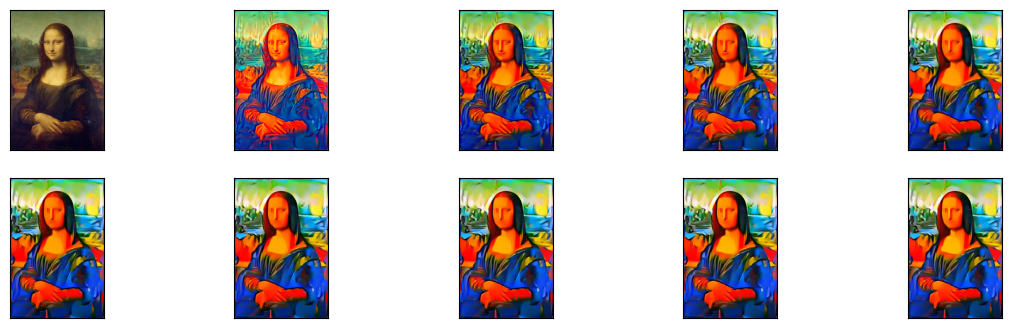

In [114]:
best, best_loss = run_style_transfer(content_path,style_path, num_iterations=1000)

Total loss: 12222.88


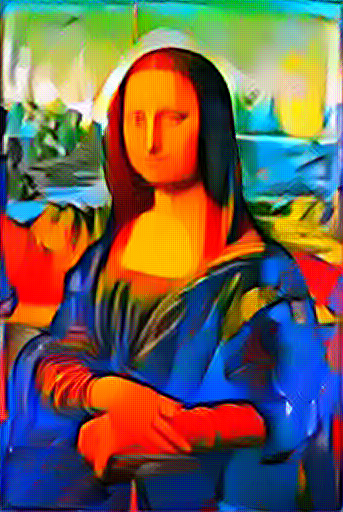

In [115]:

# Print the total loss
print("Total loss:", best_loss.numpy())


# Display the best generated image
Image.fromarray(best)
